# Analysis of the fluorescence recovery on parasite coats

The script gets its input from a config yml configuration file:
```yaml
filelist: /path/to/filelist.csv
summary: /path/to/results.csv
```
with filelist a csv file with columns 

|Filename| Start time [min]| First frame|
|--------|-----------------|------------|

where Filename column pointing to a TIF image file with a matching -profile.csv file with the columns 

|Frame|Time [min]|Mean Intensity|
|-----|----------|--------------|

Finally, summary is the path to a csv file with the result of the analysis by the imagej macro.

## Load dataset
Open the config.yaml file and load the intensity profile for each file listed in the filelist.

In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.signal import medfilt
import time

tag = time.strftime('%d%m%y', time.localtime())
print(f'Saving results with tag {tag}')

def madstd(x):
    """Maximum absolute deviation of the standard deviation"""
    return 1.4826 * np.median(np.abs(x-np.median(x)))

def f1(s):             
    return madstd(s.to_frame())
f1.__name__ = 'madstd'
q25 = partial(pd.Series.quantile, q=0.25)
q25.__name__ ='25%'
q50 = partial(pd.Series.quantile, q=0.50)
q50.__name__ ='50%'
q75 = partial(pd.Series.quantile, q=0.75)
q75.__name__ ='75%'
def f2(s):             
    return pd.Series.quantile(s,0.75) -  pd.Series.quantile(s,0.25)
f2.__name__ ='25%-75%'

def resample_intensities(p:pd.DataFrame, x:np.ndarray, metric:str):
    y = np.interp(x, p['Time [min]'], p[metric])
    y0, y1 = p[metric].min(), p[metric].max()    
    z = (y - y0) / (y1 - y0)
    return pd.DataFrame({'Parasite':[p['Parasite'].iloc[0] for k in x], 
                         'Time [min]':x, 
                         metric: y, 
                         f'Normalized {metric}':z})

Saving results with tag 070224


Load the summary.csv table

In [2]:
# Load the configuration file
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

folder = Path(config['summary']).parent

# Load the summary file
summary = pd.read_csv(config['summary'])

# Decode the parasite index 
summary['Parasite'] = summary['Image'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
summary.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Drop previous estimate of model parameters
summary.drop(columns=['Time mid point [min]','Time constant [min]', '5%-95% recovery time [min]', 'Intensity amplitude [au]','Intensity offset [au]','Photo-bleaching [min]','R squared'], inplace=True)

summary.head()

,Image,Start time [min],First frame,Image width,Image height,Image slices,Image frames,Image pixel size,Image spacing,Image frame interval,Objective,Camera,Numerical Aperture,Parasite
0,Parasite1_from video on manuscript_211013_GFPR...,60,1,142,142,17,21,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,1
1,Parasite2_from video on manuscript_211013_GFPR...,60,11,172,150,17,26,0.065091,0.4,29.971338,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,2
2,Parasite3_211013_GFPRNF_RHtomato_30min_2min001...,30,1,155,148,13,10,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,3
3,Parasite4_211013_GFPRNF_RHtomato_30min_2min001...,30,4,126,138,13,7,0.065091,0.4,127.162109,SR Apo TIRF AC 100xH,Hamamatsu Dual C11440-22C,1.49,4
4,Parasite5_231129_23MIN_1min.nd2 - 231129_23MIN...,23,1,42,55,9,16,0.233051,0.7,60.705688,Plan Fluor 40x Oil DIC H N2,Prime 95B A21B203017,1.30,5


Combine all profiles in one dataframe

In [3]:

# Load the filelist in a dataframe
filelist = pd.read_csv(config['filelist'])

# Decode the parasite index
filelist['Parasite'] = filelist['Filename'].transform(lambda x: int(x.split('_')[0].replace('Parasite','')))

# Order the files
filelist.sort_values(by='Parasite', inplace=True, ignore_index=True)

# Define a loading function for the profile files
def load_profile(folder, row):
    path = folder / row['Filename'].replace('.tif','-profile.csv')
    df = pd.read_csv(path)
    df['Parasite'] = row['Parasite']
    # Drop previous estimate of model
    df.drop(columns=['Model'], inplace=True)
    return df
    
# Load the individual intensity profiles from *-profile.csv files saved by the ImageJ macro
profiles = pd.concat([load_profile(folder, row) for row in filelist.iloc], ignore_index=True)

profiles.to_csv(folder/'all profiles.csv')

profiles.head()


,Frame,Time [min],Mean intensity,Fraction,Parasite
0,1,60.499522,109.944005,0.026449,1
1,2,60.999045,110.122265,0.040593,1
2,3,61.498567,110.066081,0.040723,1
3,4,61.998089,110.600591,0.051829,1
4,5,62.497612,111.520249,0.100390,1


In [4]:
t = np.arange(20,120,0.25)
interpolated_int = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t, metric='Mean intensity')).droplevel('Parasite')
interpolated_vol = profiles.groupby('Parasite').apply(partial(resample_intensities,x=t, metric='Fraction')).droplevel('Parasite')

## Erf function model
Re-estimate the parameters from the mean intensity profiles.

In [5]:
figure_folder = folder / f'figure_{tag}_erf'
figure_folder.mkdir(parents=True, exist_ok=True)
print(figure_folder)

/home/jeromeb/work/userdata/Randow_group/anac/parasite coat rnf213/Videos to analyse/figure_070224_erf


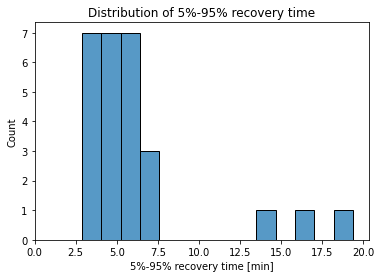

In [6]:
def model_erf(x,a,b,c,d,e):    
    """Error function + exponention"""
    return  a + b * erf((x-c) / d) * np.exp(-x / e)

def initialize_erf_parameters(x,y,alpha=0.2):
    ym = medfilt(y,3)
    a, b = np.percentile(ym, 5), np.percentile(ym, 90)    
    alpha = 0.2
    y0, y1, y2 = a + alpha * (b - a), a + (1-alpha) * (b - a), 0.5*(a+b)
    x0, x1, x2 = 0.0, 0.0, 0.0
    corr = 2 * erfinv(1 - alpha)  
    for i, yi in enumerate(ym):
        if i > 0:  
            if yi > y0 and x0 == 0 :
                x0 = x[i-1] + (y0 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
            if yi > y1 and x1 == 0 :
                x1 = x[i-1] + (y1 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
            if yi > y2 and x2 == 0 :
                x2 = x[i-1] + (y2 - y[i-1]) * (x[i] - x[i-1]) / (yi - y[i-1])
    x2=(x0+x1)/2
    p = [0.5*(a+b), 0.5*(b - a), x2  , (x1-x0)/corr, 50]
    l = [0.3*(a+b), 0.3*(b - a), x2-1, 0, 10]
    u = [0.6*(a+b), 0.7*(b - a), x2+1, 1e3, 1e9]    
    return {'p0':p, 'bounds':(l,u)}

def fit_erf_model(name, group, metric):
    """Least square fit of the model parameters"""    
    x, y = group['Time [min]'], group[metric]
    x = np.array(x[np.isfinite(y)])
    y = np.array(y[np.isfinite(y)])    
    init = initialize_erf_parameters(x,y)        
    p, cov = curve_fit(model_erf, x, y, **init)        
    return {
        'Parasite': name,
        'Offset [au]': p[0],
        'Amplitude [au]': p[1],
        'Time mid point [min]': p[2],
        'Time constant [min]': p[3],
        'Exponential decay [min]': p[4],        
        '5%-95% recovery time [min]': 2 * erfinv(0.9) * p[3],
        'R2': 1 - np.square(model_erf(x,*p)-y).sum() / np.square(y-y.mean()).sum()
    }

parameters_erf = pd.DataFrame.from_records([fit_erf_model(n,g,'Mean intensity') for n, g in profiles.groupby('Parasite')])
sns.histplot(parameters_erf, x='5%-95% recovery time [min]')
plt.title('Distribution of 5%-95% recovery time');
plt.xlim(0,parameters_erf['5%-95% recovery time [min]'].max()+1)
plt.savefig(figure_folder/'histogram of recovery times.pdf')

Customized statistics

In [7]:
parameters_erf.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2])


,Parasite,Offset [au],Amplitude [au],Time mid point [min],Time constant [min],Exponential decay [min],5%-95% recovery time [min],R2
count,27.000000,27.000000,27.000000,27.000000,27.000000,2.700000e+01,27.000000,27.000000
mean,14.000000,189.989177,66.066655,56.830112,2.642117,3.827764e+08,6.146025,0.983897
std,7.937254,51.196800,43.870973,19.969041,1.726974,4.360981e+08,4.017242,0.024441
min,1.000000,119.707222,9.741813,29.379228,1.240663,9.544860e+01,2.885998,0.870090
25%,7.500000,155.363338,41.017415,42.187765,1.774495,1.899630e+02,4.127785,0.982531
50%,14.000000,171.073748,58.889151,51.803749,2.139556,1.189072e+08,4.976979,0.990532
75%,20.500000,229.755755,75.411514,68.114827,2.583068,9.999993e+08,6.008667,0.994374
max,27.000000,304.760213,186.775902,102.227980,8.324479,1.000000e+09,19.364189,0.999324
madstd,10.378200,45.576464,27.994129,20.926704,0.683920,1.762917e+08,1.590918,0.007270
25%-75%,13.000000,74.392417,34.394099,25.927062,0.808573,9.999991e+08,1.880882,0.011842


In [8]:
col = '5%-95% recovery time [min]'
outlier_threshold =  parameters_erf[col].median() + 3 * madstd(parameters_erf[col])
print(f'Outliers are > {outlier_threshold} ')
idx = parameters_erf[col] > outlier_threshold
parameters_erf.loc[idx]

Outliers are > 9.749733832083514 


,Parasite,Offset [au],Amplitude [au],Time mid point [min],Time constant [min],Exponential decay [min],5%-95% recovery time [min],R2
11,12,156.325324,61.579055,48.931484,8.324479,1.503706e+02,19.364189,0.985628
12,13,151.342043,34.144651,45.305554,5.810840,5.989027e+07,13.517026,0.986570
16,17,175.650116,60.172524,51.803749,7.306931,1.675726e+02,16.997196,0.971355


 Heatmaps

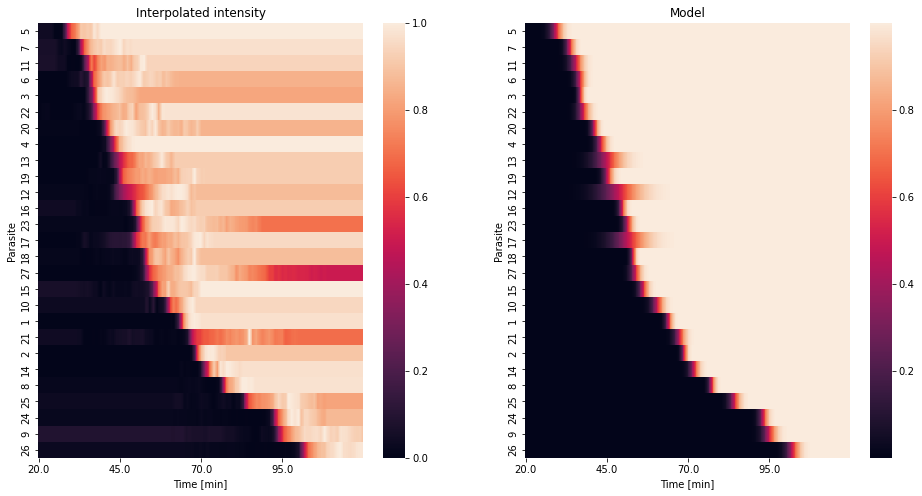

In [9]:

def generate_erf_models(p:pd.DataFrame, x:np.ndarray):
    """Generate models profiles from parameters and time values"""
    yhat = model_erf(x, p[1],p[2],p[3],p[4],p[5])
    return pd.DataFrame({
        'Parasite': [p['Parasite'] for x in range(len(x))],
        'Time [min]' : x,
        'Model [au]': yhat,
        'Normalized model [au]': model_erf(x, 0.5, 0.5, p[3], p[4], 1e6),        
    })


models_erf = pd.concat([generate_erf_models(p,t) for p in parameters_erf.iloc])

order = np.argsort(parameters_erf['Time mid point [min]']).to_numpy() + 1

fig, ax = plt.subplots(1,2,figsize=(16,8))

sns.heatmap(
    interpolated_int.pivot_table('Normalized Mean intensity', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 100,
    linewidths = 0.0,     
    rasterized = True,
    vmin=0,
    vmax=1,
    ax=ax[0])
plt.xlim([20,125])
ax[0].set_title('Interpolated intensity')

sns.heatmap(
    models_erf.pivot_table('Normalized model [au]', 'Time [min]', 'Parasite').transpose().reindex(order),
    xticklabels = 100,
    linewidths = 0.0, 
    rasterized = True,
    #vmin=0,
    #vmax=1,
    ax=ax[1])
ax[1].set_title('Model')
plt.savefig(figure_folder/'heatmap.pdf')
plt.show()


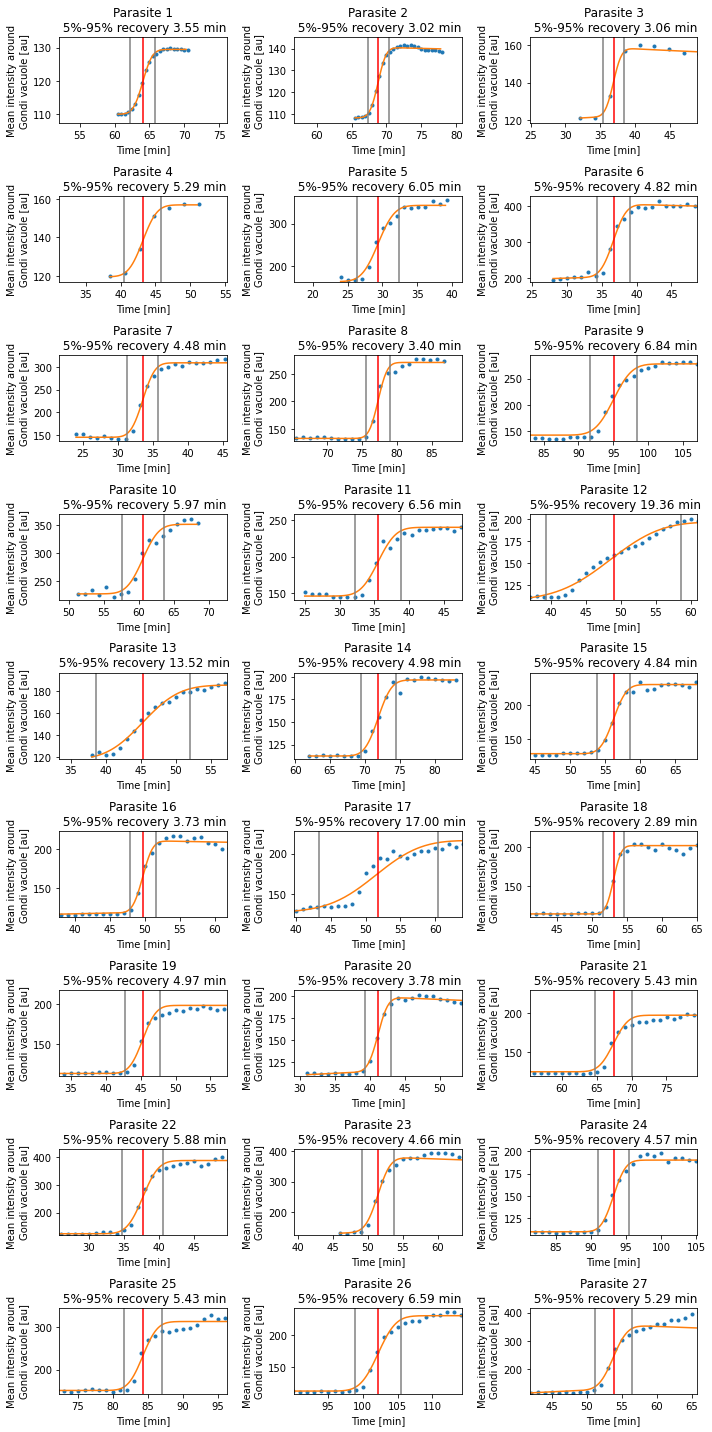

In [10]:
def plot_erf(profile, parameter, ax):    
    ax.plot(profile['Time [min]'], profile['Mean intensity'], '.')
    x = np.arange(profile['Time [min]'].min(), profile['Time [min]'].max(), 0.25)    
    y0, y1 = 0.975*profile['Mean intensity'].min(), 1.025*profile['Mean intensity'].max()
    p = parameter.iloc[0]
    yhat = model_erf(x, *p[1:6])
    ax.plot(x,yhat)
    t2 = p[3]
    dt = p[6]/2    
    ax.plot([t2,t2],[y0,y1],color='red')
    ax.plot([t2+dt,t2+dt],[y0,y1],color='gray')
    ax.plot([t2-dt,t2-dt],[y0,y1],color='gray')
    pid = parameter["Parasite"].item()
    ax.set_title(f'Parasite {pid}\n 5%-95% recovery {2*dt:.2f} min')
    ax.set_xlim([t2-12, t2+12])
    ax.set_ylim(y0,y1)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Mean intensity around\nGondi vacuole [au]')
    
fig,ax = plt.subplots(9,3,figsize=(10,20))
for p in parameters_erf['Parasite']:
    plot_erf(profiles[profiles['Parasite']==p], parameters_erf[parameters_erf['Parasite']==p],ax=ax.ravel()[p-1])
fig.tight_layout()
plt.savefig(figure_folder/f'intensity for all parasites.pdf',  bbox_inches='tight')


Save all profiles as individual graph

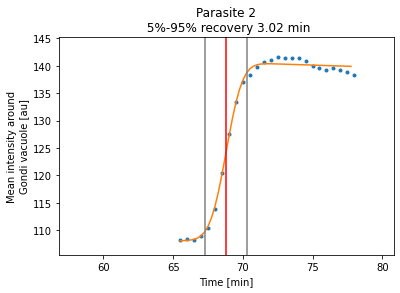

In [11]:
for p in [1,2]:
    plt.clf()
    plot_erf(profiles[profiles['Parasite']==p], parameters_erf[parameters_erf['Parasite']==p],ax=plt.gca())            
    plt.savefig(figure_folder/f'intensity parasite {p}.pdf',  bbox_inches='tight')

Export all data into an MS Excel spreadsheet.

In [12]:
with pd.ExcelWriter(figure_folder/'Parasite coat recovery data.xlsx') as xls:
    summary.to_excel(xls,sheet_name='Info',index=False)
    parameters_erf.to_excel(xls,sheet_name='Model parameters',index=False)
    parameters_erf.agg(["count","mean", "std", "min",q25, q50, q75, "max",  f1, f2]).to_excel(xls,sheet_name='Statistics')
    for n,g in profiles.groupby('Parasite'):
        g.reset_index().drop(columns=['index','Parasite']).to_excel(xls,sheet_name=f'Parasite {n}',index=False)